In [65]:
import torch as tc 
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split 


import torchvision as tv 
from torchvision import transforms as T 
from torchvision import datasets 
from torchvision import models 

from torchmetrics import Accuracy

from tqdm import tqdm 

import numpy as np 
import matplotlib.pyplot as plt 

import copy

In [66]:
device = 'cuda' if tc.cuda.is_available() else 'cpu'
device

'cuda'

In [67]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [68]:
def train_one_epoch(model, train_loader, loss_func, optimizer, epoch):
    model.train()

    train_loss=AverageMeter()
    train_acc=Accuracy(task='multiclass', num_classes=10).to(device)

    with tqdm(train_loader, unit='batch') as tepoch:
        for x, y in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch={epoch}')

            x=x.to(device)
            y=y.to(device)

            yp=model(x)

            loss=loss_func(yp.squeeze(),  y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss.item())
            train_acc(yp.squeeze(), y.int())

            tepoch.set_postfix(loss=train_loss.avg, Accuracy=train_acc.compute().item() * 100)

    return model, train_loss.avg, train_acc.compute().item() * 100

In [69]:
def validation(model, valid_loaedr, loss_func):
    model.eval()

    valid_loss=AverageMeter()
    valid_acc=Accuracy(task='multiclass', num_classes=10).to(device)

    for x, y in valid_loaedr:

        x=x.to(device)
        y=y.to(device)

        yp=model(x)
        loss=loss_func(yp.squeeze(), y)

        valid_loss.update(loss.item())
        valid_acc(yp.squeeze(), y)

    print(f'valid loss={valid_loss.avg:.4}, accuracy={valid_acc.compute().item() * 100 :.4}')
    print()

    return valid_loss.avg, valid_acc.compute().item() * 100

In [70]:
train_transform = T.Compose([T.ToTensor(),
                             T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = T.Compose([T.ToTensor(), 
                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [71]:
train_dataset = datasets.CIFAR10(root =  '/home/ahmadrezabaqerzadeh/datasets/', train = True, download = True, transform = train_transform)
test_dataset  = datasets.CIFAR10(root = '/home/ahmadrezabaqerzadeh/datasets/', train = False, download = True, transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [72]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [73]:
x, y = next(iter(train_loader))

In [74]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = nn.Dropout(0.1)(self.fc(out))
        out = self.relu(out)
        out = nn.Dropout(0.1)(self.fc1(out))
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [75]:
model = LeNet5(10)

In [76]:
model = model.to(device)

In [89]:
optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 5e-4)
loss_func = nn.CrossEntropyLoss()

In [78]:
loss_train_hist, acc_train_hist = [], []
loss_valid_hist, acc_valid_hist = [], []

best_loss = tc.inf 
best_model = [0]

In [90]:
start, end = 20, 25
for i in range(start, end):

  model, train_loss, train_acc = train_one_epoch(model, train_loader, loss_func, optimizer, i)
  valid_loss, valid_acc = validation(model,test_loader,loss_func)

  acc_train_hist.append(train_acc)
  loss_train_hist.append(train_loss)

  acc_valid_hist.append(valid_acc)
  loss_valid_hist.append(valid_loss)

  if valid_loss<best_loss:
    best_loss = valid_loss
    best_model[0] = copy.deepcopy(model)
    print('model saved!')

Epoch=20: 100%|██████████| 1563/1563 [00:23<00:00, 67.73batch/s, Accuracy=78.9, loss=0.595]


valid loss=1.076, accuracy=65.47



Epoch=21: 100%|██████████| 1563/1563 [00:23<00:00, 66.82batch/s, Accuracy=79, loss=0.589]  


valid loss=1.084, accuracy=65.49



Epoch=22: 100%|██████████| 1563/1563 [00:24<00:00, 64.23batch/s, Accuracy=79.1, loss=0.585]


valid loss=1.091, accuracy=65.26



Epoch=23: 100%|██████████| 1563/1563 [00:24<00:00, 63.42batch/s, Accuracy=79.2, loss=0.583]


valid loss=1.086, accuracy=65.31



Epoch=24: 100%|██████████| 1563/1563 [00:25<00:00, 60.83batch/s, Accuracy=79.3, loss=0.582]


valid loss=1.091, accuracy=65.28



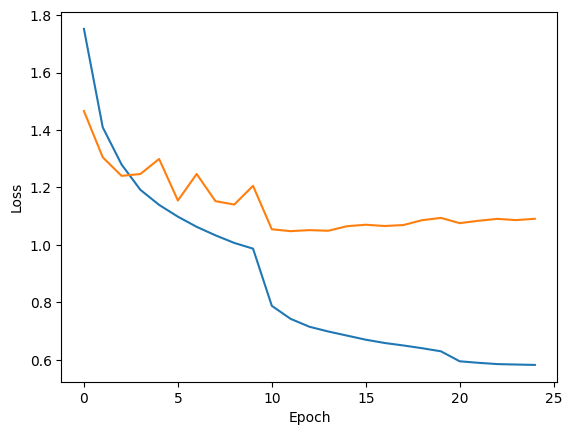

In [91]:
plt.plot(range(end), loss_train_hist, label = 'Train Loss') 
plt.plot(range(end), loss_valid_hist, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

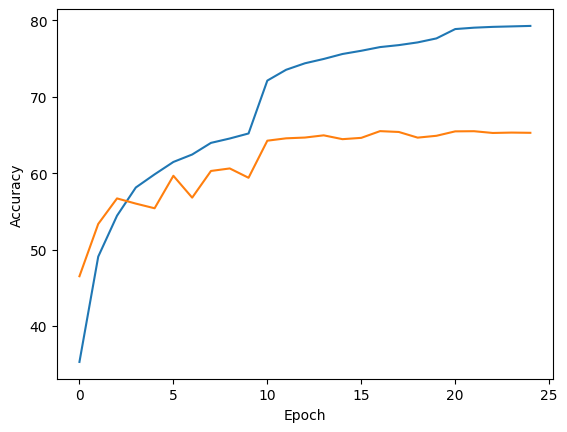

In [92]:
plt.plot(range(end), acc_train_hist, label = 'Train Accurcay') 
plt.plot(range(end), acc_valid_hist, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [95]:
tc.save(model.state_dict(), '/home/ahmadrezabaqerzadeh/AI/git/repo18/TeacherModel.pt')